In [1]:
import numpy as np
import simpy 
import matplotlib.pyplot as plt
import itertools
import random
%matplotlib notebook

In [76]:
def NO_DVS():
    Energy_cost = 1
    slowdown_factory = 1
    return Energy_cost,slowdown_factory

def DVS(slowdown_factory):
    
#     voltage = (int(((1-0.5)*slowdown_factory+0.5)/0.05)+1)*0.05
    voltage = (slowdown_factory+1)*0.5
    Energy_cost = Energy_consumption(voltage)
    return Energy_cost

def CS_DVS(slowdown_factory):
    
#     voltage = (int(((1-0.5)*slowdown_factory+0.5)/0.05)+1)*0.05
    voltage = (slowdown_factory+1)*0.5
    if slowdown_factory <= CRITICAL_SPEEDN:
        slowdown_factory = CRITICAL_SPEEDN
        voltage = (CRITICAL_SPEEDN+1)*0.5
    Energy_cost = Energy_consumption(voltage)
    return Energy_cost


def generate_speed():
    return np.random.uniform(0,1)

def deadline_time():
    return np.random.uniform(10,50)

def generate_tasks():
    return np.random.uniform(5,20)

def generate_WCET():
    return np.random.uniform(1,5)


def Energy_consumption(voltage):
    
    Ceff = 0.43
    
    E_AC = Ceff*np.power(voltage,2)

    E_DC = np.exp(voltage*1.35)*np.exp(-voltage*6)*6*voltage+0.19*np.power(voltage,4)

    E_on = np.exp(voltage*0.48)*np.exp(-voltage*5.38)*5*voltage
    
    E_total = E_AC + E_DC + E_on
    
    return E_total/0.712

def voltage_assignment():
    return 0.5 + 0.05*np.random.randint(0,10)


In [77]:
import simpy
CRITICAL_SPEEDN = 0.486

SIM_DURATION = 200
cost_time = 0
end_time = 0
cost_list = []
slow_list = []
# global processor_status
# processor_status = 0
deadlinelist = []
# global WECT_list
WECT_list = []
slowdownlist = []
slow_dvs =[]
sdlist = []

temlist=[]
time_line = []
time_line.append(0)

Start_time_list = []
dead_line_list = []
Start_time = 0
execute_time = []
completing_time = []

slack_csdvsp_energysmallthan41 = []



class Task(object):
    """This class represents the propagation through a task."""
    def __init__(self, env, delay):
        self.env = env
        self.delay = delay
        self.store = simpy.Store(env)

    def latency(self, value):
        yield self.env.timeout(self.delay)
        self.store.put(value)

    def put(self, value):
        self.env.process(self.latency(value))

    def get(self):
        return self.store.get()


def sender(env, task):
    """A process which randomly generates messages."""
    while True:
        # wait for next transmission
        for i in itertools.count():
            yield env.timeout(generate_tasks())
            task.put('Task %d Sender sent this at %d'  % (i,env.now))
            if i == 0:
                Start_time = env.now


def receiver(env, task,algorithm):
    """A process which consumes messages."""
    while True:
        # Get event for message pipe
        msg = yield task.get()
        starting_time = int(msg.split(' ')[-1])
        deadline = (deadline_time())
        WCET = (generate_WCET())
        timepass = (starting_time+deadline) - env.now
        if timepass < 0:
            deadline = deadline + 5
            timepass = (starting_time+deadline) - env.now

#         min_slowdown_factory = WCET/deadline

#         slowdown_factory = np.random.uniform(min_slowdown_factory,1)
#         slowdown_factory = min_slowdown_factory
#         speed = max(CRITICAL_SPEEDN,slowdown_factory)
        
        
        Start_time_list.append(starting_time)
        
#         P_testing = CS_DVS_P(env,deadline,WCET,slowdown_factory,starting_time)
        
#         extend_WCET = ((WCET)/speed)

#         print(deadline - extend_WCET)
        
        
        if len(execute_time)<1:
            min_slowdown_factory = WCET/deadline
            slowdown_factory = min_slowdown_factory
            speed = max(CRITICAL_SPEEDN,slowdown_factory)
            extend_WCET = ((WCET)/speed)
            execute_time.append(deadline - extend_WCET + starting_time)
            completing_time.append(deadline + starting_time)
            saving_time = execute_time[-1] - starting_time
#             onlinetime = completing_time[-1] - starting_time
            energy_cost = CS_DVS(slowdown_factory)
#             real_cost = ((onlinetime - saving_time)/onlinetime)*energy_cost
            if min_slowdown_factory< CRITICAL_SPEEDN:
                    energy_cost = energy_cost+min_slowdown_factory**-1*0.001
            sdlist.append((min_slowdown_factory,energy_cost))
#             sdlist.append((min_slowdown_factory,real_cost))
            yield env.timeout(deadline)
        else:
            current_time = env.now
            move_time = starting_time+deadline - current_time
            if move_time < 0 :
                move_time = 0
            print(move_time,starting_time,deadline,current_time)
            yield env.timeout(move_time)
            if starting_time > completing_time[-1]:
                """scheduling algorithm add in here"""
                Newdead = env.now
                min_slowdown_factory = WCET/(Newdead-starting_time)
                slowdown_factory = min_slowdown_factory
                speed = max(CRITICAL_SPEEDN,slowdown_factory)
                extend_WCET = int(WCET)/speed
                print('ax',Newdead,extend_WCET,starting_time,WCET,speed)
                saving_time = Newdead - extend_WCET - starting_time
                print('Saving_time %d'%(saving_time))
                execute_time.append(Newdead - extend_WCET)
                completing_time.append(extend_WCET + execute_time[-1])
#                 saving_time = int(Newdead - extend_WCET - starting_time)
#                 onlinetime = Newdead - starting_time
                energy_cost = CS_DVS(slowdown_factory)
#                 real_cost = ((onlinetime - saving_time)/onlinetime)*energy_cost
                if min_slowdown_factory < CRITICAL_SPEEDN:
                    energy_cost = energy_cost+min_slowdown_factory**-1*0.001
                if slowdown_factory <= 1:
                    sdlist.append((min_slowdown_factory,energy_cost))
                
            else:
                execute_time.append(completing_time[-1])
                Newdead = env.now
                min_slowdown_factory = WCET/(Newdead-execute_time[-1])
                slowdown_factory = min_slowdown_factory
                speed = max(CRITICAL_SPEEDN,slowdown_factory)
                extend_WCET = WCET/speed
                completing_time.append(extend_WCET+execute_time[-1])
                saving_time = 0
#                 onlinetime = Newdead - starting_time
                energy_cost = CS_DVS(slowdown_factory)
#                 real_cost = ((onlinetime - saving_time)/onlinetime)*energy_cost
                if min_slowdown_factory< CRITICAL_SPEEDN:
                    energy_cost = energy_cost + min_slowdown_factory**-1*0.001
                if slowdown_factory <= 1:
                    sdlist.append((min_slowdown_factory,energy_cost))
                
  
        print('extend_WCET %.2f'%extend_WCET,speed,int(WCET),int(deadline),slowdown_factory,min_slowdown_factory)
        Energy_cost = algorithm(slowdown_factory)
      

        cost_list.append(Energy_cost)
        Q = CS_DVS(slowdown_factory)
        if slowdown_factory < 1:
            slow_list.append((slowdown_factory,Energy_cost))
        
            slow_dvs.append((slowdown_factory,Q))

            
        dead_line_list.append((env.now + extend_WCET))
        detal_time = deadline-starting_time-(completing_time[-1]-execute_time[-1])
        if slowdown_factory < 0.41:
            slack_csdvsp_energysmallthan41.append((slowdown_factory,Q,detal_time))
#         yield env.timeout(deadline)
        
        print('%s ms, Execute this at %d ms complete at %d ms, deadline at %d ms, Slowdown_factory: %.2f, Energy_cost: %.2f' 
              % (msg, execute_time[-1], completing_time[-1], (env.now), slowdown_factory, Energy_cost))
#         yield env.timeout(extend_WCET)
        


# Setup and start the simulation
print('Event under CS_DVS_P')
env = simpy.Environment()
# np.random.seed(1)
task = Task(env, 0)
env.process(sender(env, task))
env.process(receiver(env,task,DVS)) 

env.run(until=SIM_DURATION)

Event under CS_DVS_P
('extend_WCET 9.51', 0.486, 4, 12, 0.3734321400274228, 0.3734321400274228)
Task 0 Sender sent this at 6 ms, Execute this at 8 ms complete at 18 ms, deadline at 18 ms, Slowdown_factory: 0.37, Energy_cost: 0.75
(21.246050536932717, 24, 21.305445133307455, 24.05939459637474)
('ax', 45.30544513330746, 8.23045267489712, 24, 4.569849611767678, 0.486)
Saving_time 13
('extend_WCET 8.23', 0.486, 4, 21, 0.21449209735700342, 0.21449209735700342)
Task 1 Sender sent this at 24 ms, Execute this at 37 ms complete at 45 ms, deadline at 45 ms, Slowdown_factory: 0.21, Energy_cost: 0.78
(34.39611671688384, 30, 49.701561850191304, 45.30544513330746)
('extend_WCET 5.79', 0.486, 2, 49, 0.0817982137162072, 0.0817982137162072)
Task 2 Sender sent this at 30 ms, Execute this at 45 ms complete at 51 ms, deadline at 79 ms, Slowdown_factory: 0.08, Energy_cost: 0.84
(0, 44, 17.51670886685649, 79.7015618501913)
('extend_WCET 10.03', 0.486, 4, 17, 0.17045394220718713, 0.17045394220718713)
Task 3 

In [82]:
sorted(sdlist)

[(0.031361179623779975, 0.7812792031470097),
 (0.04605980581819397, 0.7711035509895976),
 (0.0817982137162072, 0.7616178533151273),
 (0.09252530244632574, 0.7602005019061715),
 (0.1104266380333365, 0.7584484334507159),
 (0.15276852032711719, 0.7559384986616502),
 (0.17045394220718713, 0.755259334904606),
 (0.18982134928821737, 0.7546607588008957),
 (0.21449209735700342, 0.7540548239020798),
 (0.22205513312062788, 0.7538960335757516),
 (0.3734321400274228, 0.7520705101787513),
 (0.4, 0.7493926474754323),
 (0.4, 0.7493926474754323),
 (0.42000000000000004, 0.7493926474754323),
 (0.43000000000000005, 0.7493926474754323),
 (0.44000000000000006, 0.7493926474754323),
 (0.4600000000000001, 0.7493926474754323),
 (0.4600000000000001, 0.7493926474754323),
 (0.4800000000000001, 0.7493926474754323),
 (0.4900000000000001, 0.7497957124643599),
 (0.5000000000000001, 0.7509128470067331),
 (0.5200000000000001, 0.7536159465468361),
 (0.5200000000000001, 0.7536159465468361),
 (0.5400000000000001, 0.756943

<IPython.core.display.Javascript object>


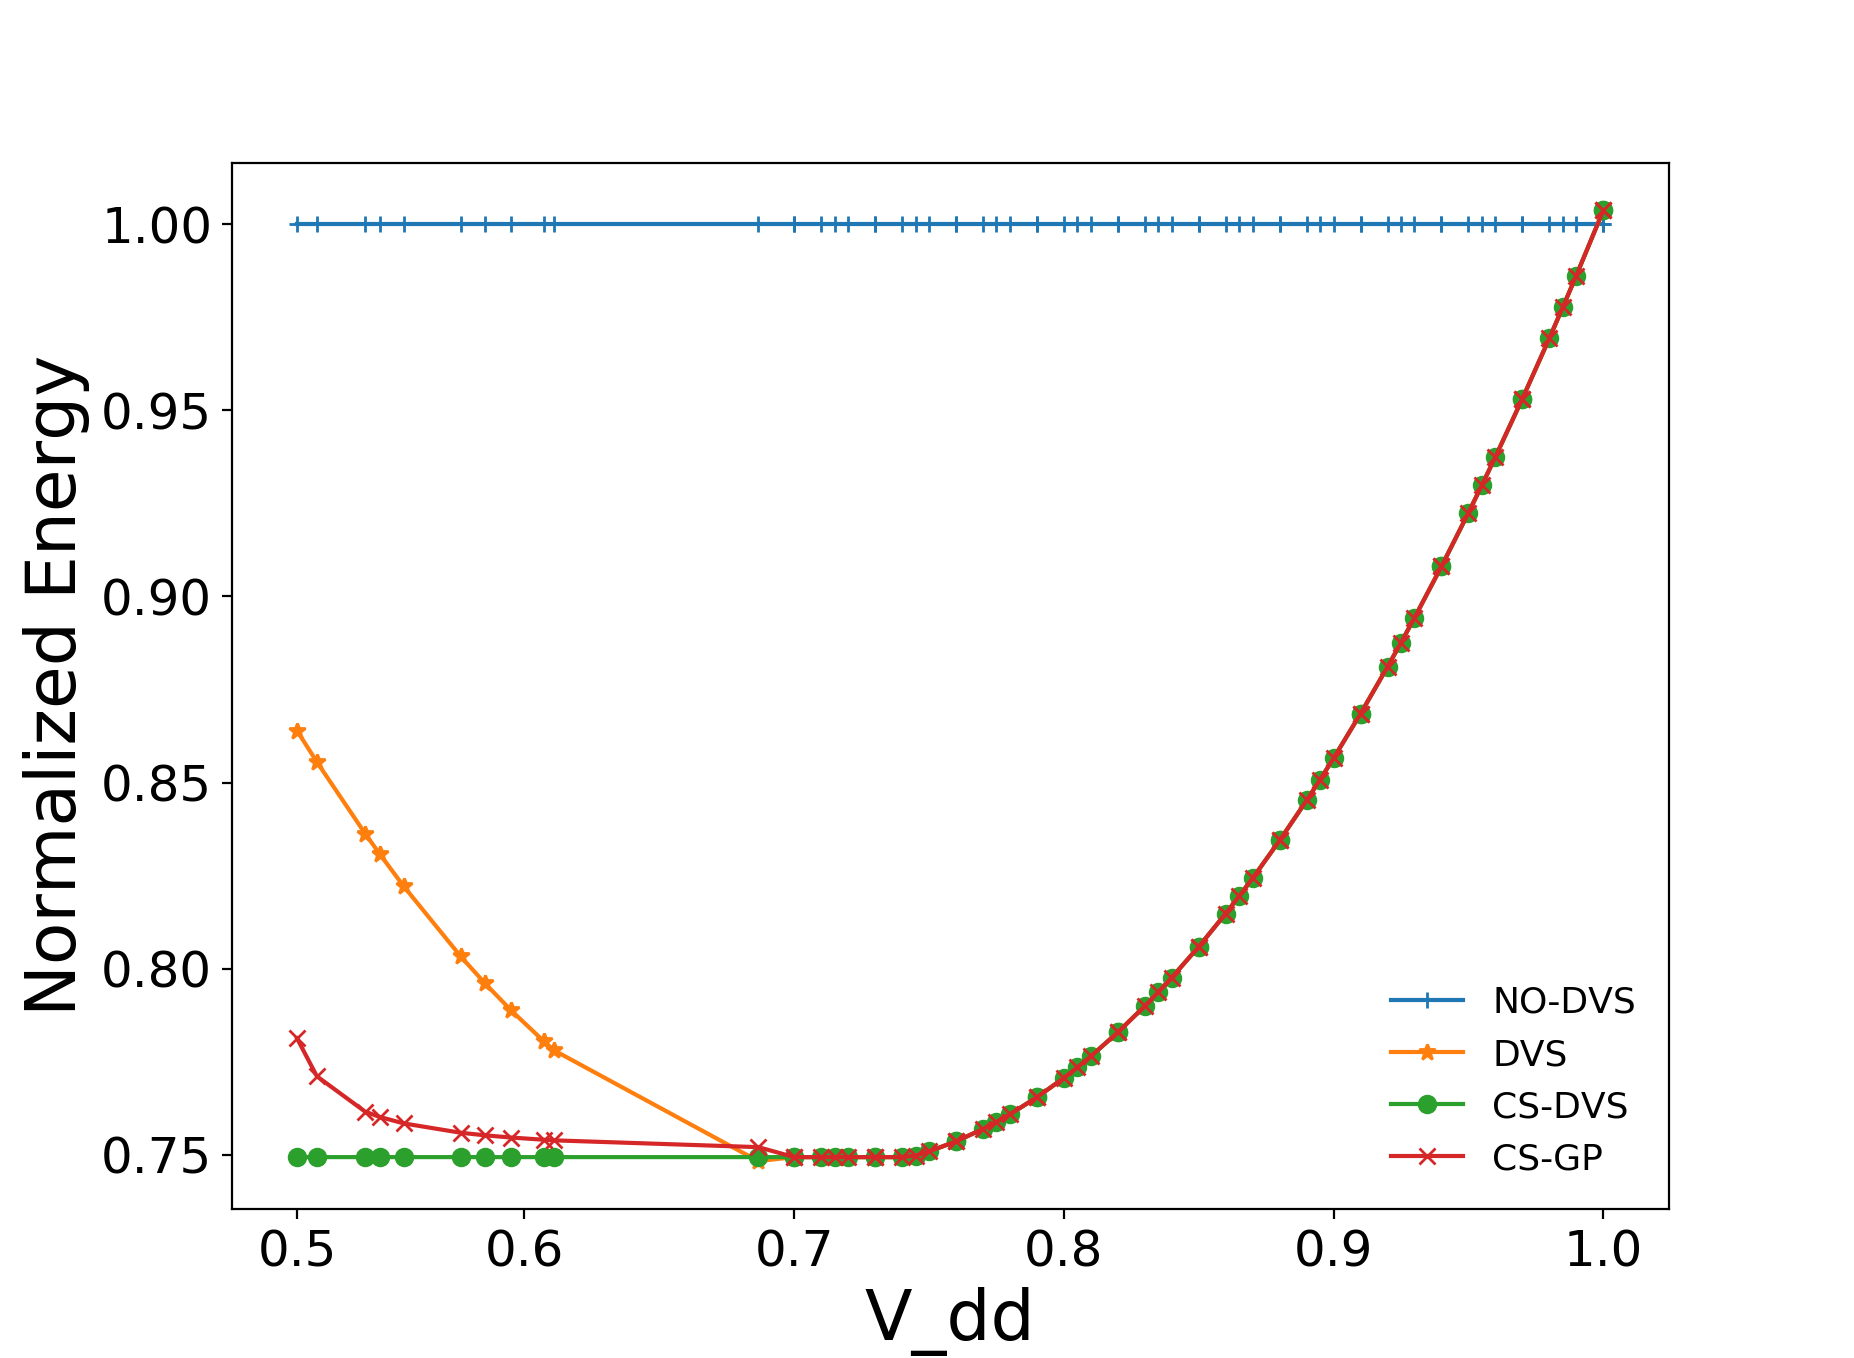

In [88]:
%matplotlib notebook
a = sorted(slow_list)
u = [x[0] for x in a]
q = [x[1] for x in a]
b = sorted(slow_dvs)
c = sorted(sdlist)
ub = [x[0] for x in b]
qb = [x[1] for x in b]
uc = [x[0] for x in c]
qc = [x[1] for x in c]
nx = np.ones(len(u))


plt.plot(u,nx,'-+',label= 'NO-DVS')
plt.plot(u,q,'-*',label='DVS')
plt.plot(ub,qb,'-o',label='CS-DVS')
plt.plot(uc,qc,'-x',label='CS-GP')
plt.yticks(fontsize = 18)
first_label = c[0][0]
plt.xticks([first_label, 0.2,0.4,0.6,0.8,1.0],['0.5','0.6','0.7','0.8','0.9','1.0'],fontsize = 18)
plt.ylabel('Normalized Energy',fontsize = 25)
plt.xlabel('V_dd',fontsize = 25)
# plt.ylim(0.75,1.01)
# plt.xlim(0.07,1.03)
plt.legend(fontsize = 13,frameon=False)
plt.show()

In [83]:
c[0][0]

0.031361179623779975

In [80]:
for ui in np.arange(0.4,1.01,0.02):
#     voltage = (ui+1)*0.5
    print(ui,CS_DVS(ui))
    slow_list.append((ui,CS_DVS(ui)))
    
    slow_dvs.append((ui,CS_DVS(ui)))
    sdlist.append((ui,CS_DVS(ui)))

(0.4, 0.7493926474754323)
(0.42000000000000004, 0.7493926474754323)
(0.44000000000000006, 0.7493926474754323)
(0.4600000000000001, 0.7493926474754323)
(0.4800000000000001, 0.7493926474754323)
(0.5000000000000001, 0.7509128470067331)
(0.5200000000000001, 0.7536159465468361)
(0.5400000000000001, 0.7569434246833912)
(0.5600000000000002, 0.7608943163145278)
(0.5800000000000002, 0.7654675778739056)
(0.6000000000000002, 0.7706621132539306)
(0.6200000000000002, 0.7764767976250028)
(0.6400000000000002, 0.7829104992905576)
(0.6600000000000003, 0.7899620997091918)
(0.6800000000000003, 0.797630511807207)
(0.7000000000000003, 0.8059146966973713)
(0.7200000000000003, 0.8148136789126323)
(0.7400000000000003, 0.8243265602568348)
(0.7600000000000003, 0.8344525323682078)
(0.7800000000000004, 0.8451908880854657)
(0.8000000000000004, 0.8565410317007885)
(0.8200000000000004, 0.8685024881786925)
(0.8400000000000004, 0.8810749114148565)
(0.8600000000000004, 0.8942580916043109)
(0.8800000000000004, 0.9080519

In [ ]:
a

In [ ]:
Start_time_list = np.array(Start_time_list)
dead_line_list = np.array(dead_line_list)
execute_time = np.array(execute_time)
completing_time = np.array(completing_time)
a = dead_line_list - Start_time_list[:len(dead_line_list)]
b = completing_time - execute_time


In [ ]:
Energy_consumption(1,0)

In [ ]:
slack_csdvsp_energysmallthan41

In [ ]:
0.5 + 0.05*np.random.randint(0,10)

In [ ]:
def Energy_consumption(voltage):
    index = int((voltage-0.5)/0.05)
    Ceff = 0.43
    L_g = 4*np.power(10,6)
    E_AC = Ceff*np.power(voltage,2)
    E_DC = [0.38,0.3,0.28,0.26,0.24,0.23,0.22,0.21,0.22,0.22,0.23]
    E_on = [0.25,0.18,0.13,0.1,0.09,0.06,0.05,0.04,0.03,0.02,0.01,0.05]
    E_total = E_AC + E_DC[index] + E_on[index]
#     if voltage <= 0.7:
#         E_DC = voltage*(-0.75)+0.73
# #         E_on = voltage*(-0.81)+np.power(voltage,3)*1.4
#         E_on = voltage*(-0.71)+0.58
#     else:
#         E_DC = voltage*(-0.26)+0.41
#         E_on = voltage*(-0.35)+0.462*(voltage)
# #     E_DC = [0.38,0.3,0.28,0.26,0.24,0.23,0.22,0.21,0.22,0.22,0.23]
# #     E_on = [0.25,0.18,0.13,0.1,0.09,0.06,0.05,0.04,0.03,0.02,0.01,0.005]
#     if change_voltage > 0: 
#         E_total = 0.21 + 0.20 + 0.09
#     else:
#         E_total = E_AC + E_DC + E_on
# #     if voltage >=1:
# #         E_total = 0.7
    return E_total/0.7
    
def voltage_assignment():
    return 0.5 + 0.05*np.random.randint(0,10)

# def CS_DVS_P(env,deadline,WCET,slowdown_factory,starting_time):
#     processor_status = 0
#     min_slowdown_factory = WCET/deadline
#     Zi = Zi_procrastination(deadline,WCET,slowdown_factory)
#     U = Zi
#     if Zi - (env.now - time_line[-1]) <=0:
#         print("timer <0 %.2f"%(Zi - (env.now - time_line[-1])))
#         processor_status = 1
             
#     timer = Zi
# #     if processor_status == 0:
# #         timer = Zi
# #         processor_status = 1
# #     else:
# #         timer = min(timer,Zi)
#     if processor_status == 1:
#         """add some function"""
# #         start = env.now
# #         queue_number = len(temlist)
#         execute_time = np.sum(WECT_list)
# #         yield env.timeout()
#         temlist = []
        
        
#     time_line.append(env.now)
    
#     return U

# def Zi_procrastination(deadline, WCET,slowdown_factory):
#     tem = (1/slowdown_factory)*(WCET/deadline)
#     deadlinelist.append(deadline)
#     WECT_list.append(WCET)
#     slowdownlist.append(slowdown_factory)
#     temlist.append(tem)
#     return (1-np.sum(tem))*deadline


In [ ]:
alike = []
for x in np.arange(0.5,1.05,0.05):
    alike.append(Energy_consumption(x))

In [ ]:
n = range(len(alike))
plt.plot(n,alike)
plt.show()

In [ ]:
(voltage_assignment()-0.5)/0.5

In [ ]:
slow_list.append((0.41,0.7142857142857143))

In [ ]:
Energy_consumption(0.7,1)

In [ ]:
e_dc = []
x_list = []
ceff = 0.43 * np.float_power(10,-9)
for x in np.arange(0.5,1.05,0.05):
    print(x)
    e_dc.append(ceff*np.power(x,2))
    x_list.append(x)
plt.plot(x_list,e_dc,'-o')
plt.show()

<IPython.core.display.Javascript object>


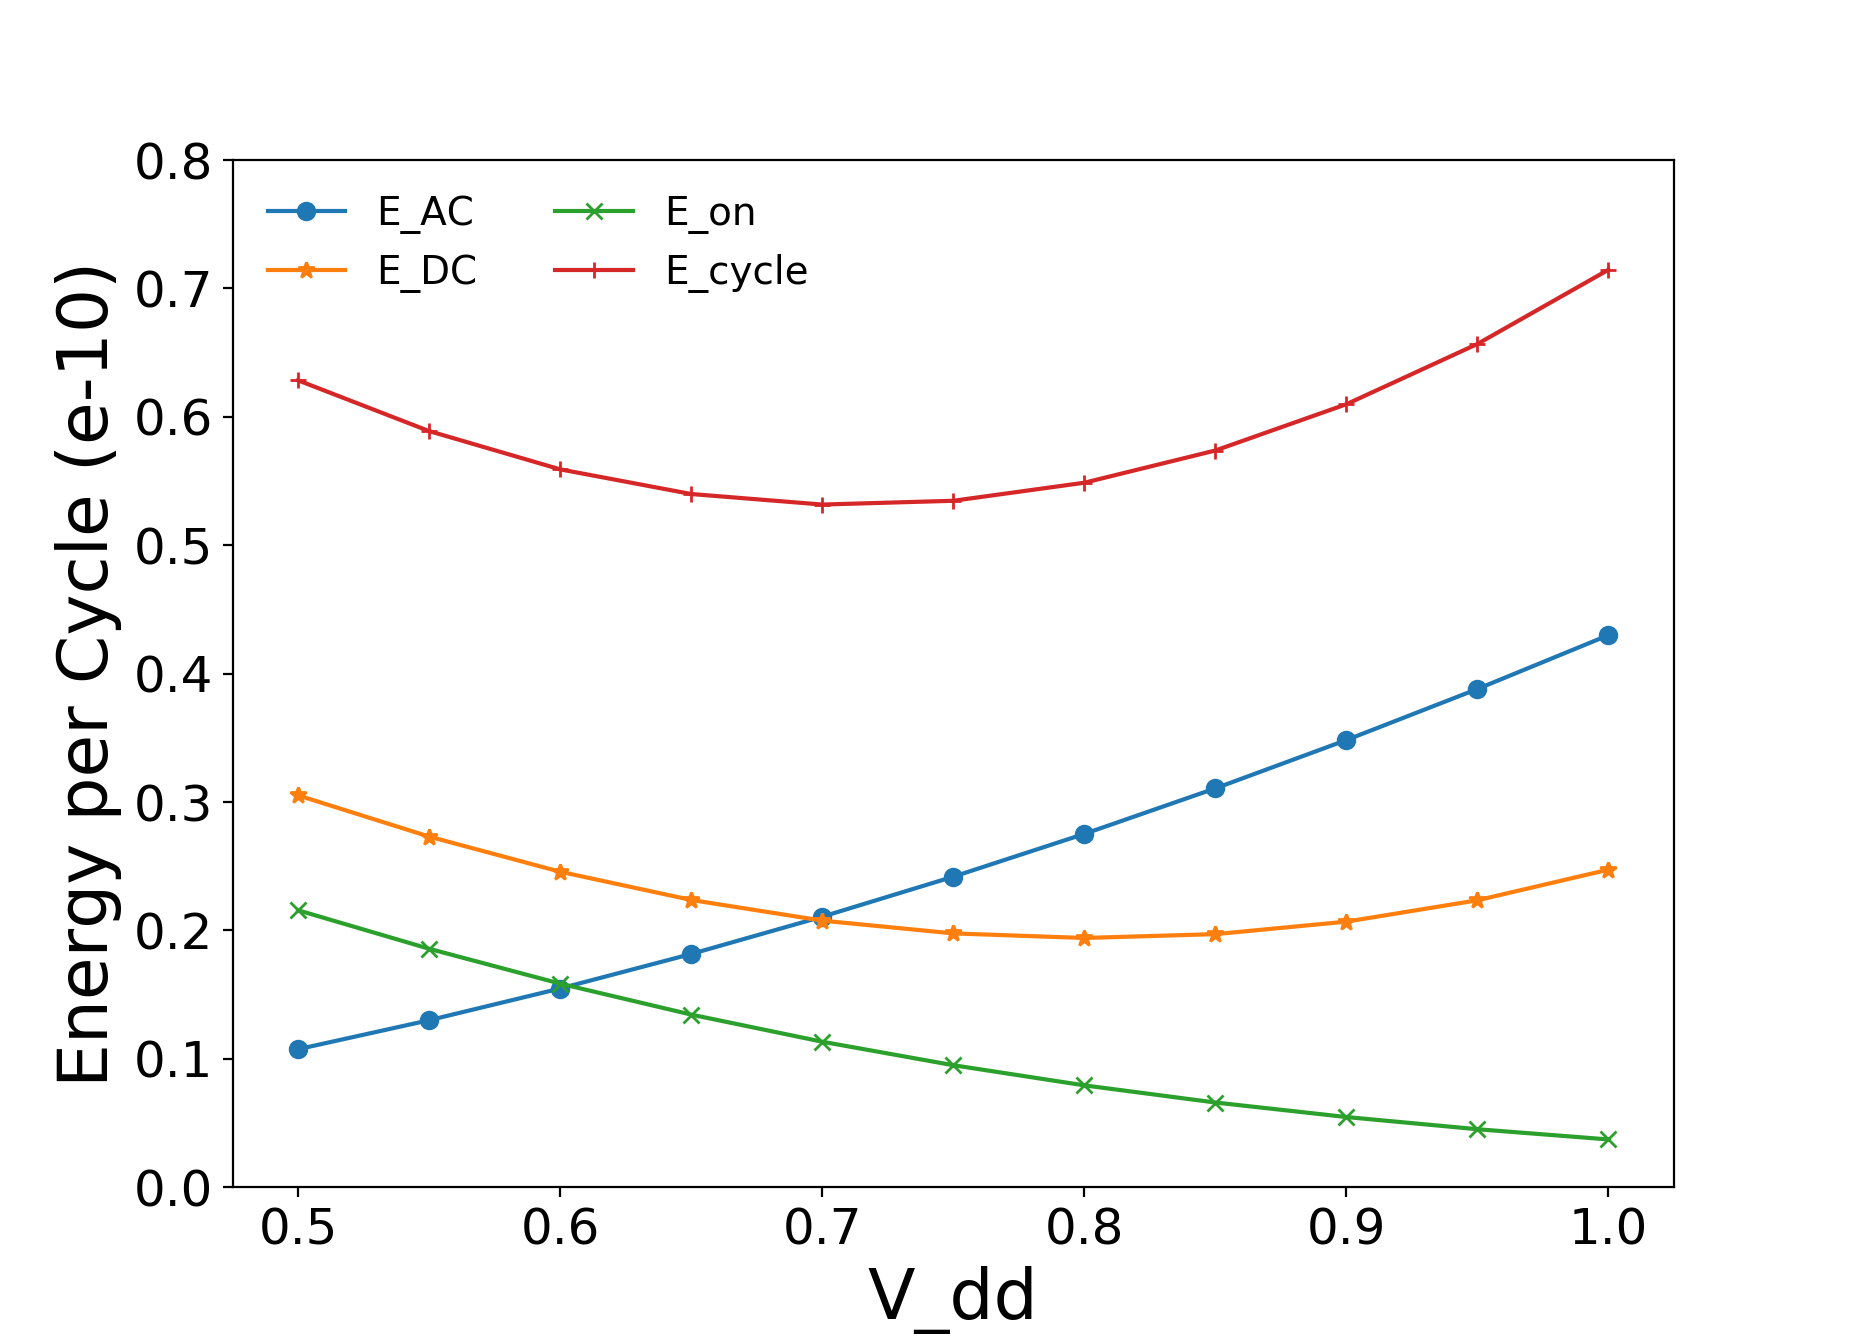

In [89]:
Ceff = 0.43

voltage = np.arange(0.5, 1.05, 0.05)

E_AC = Ceff*np.power(voltage,2)

E_DC = np.exp(voltage*1.35)*np.exp(-voltage*6)*6*voltage+0.19*np.power(voltage,4)

E_on = np.exp(voltage*0.48)*np.exp(-voltage*5.38)*5*voltage

# E_DC = np.exp(voltage*0.7)*np.exp(-voltage*5.38)*7*voltage+0.19*np.power(voltage,4)

# E_on = np.exp(voltage*0.48)*np.exp(-voltage*5.38)*6*voltage


E_total = E_AC + E_DC + E_on

plt.plot(voltage,E_AC,'-o',label='E_AC')
plt.plot(voltage,E_DC,'-*',label='E_DC')
plt.plot(voltage,E_on,'-x',label='E_on')
plt.plot(voltage,E_total,'-+',label='E_cycle')
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.ylabel('Energy per Cycle (e-10)',fontsize = 25)
plt.xlabel('V_dd',fontsize = 25)
plt.legend(fontsize = 14,frameon=False,ncol=2)
plt.ylim(0,0.8)
plt.show()

In [ ]:
def Energy_consumption1(voltage,change_voltage):
    
    Ceff = 0.43
    
    E_AC = Ceff*np.power(voltage,2)

    E_DC = np.exp(voltage*0.7)*np.exp(-voltage*5.38)*7*voltage+0.19*np.power(voltage,4)

    E_on = np.exp(voltage*0.48)*np.exp(-voltage*5.38)*6*voltage
    
    E_total = E_AC + E_DC + E_on
    
    return E_total/0.729

In [ ]:
Energy_consumption1(1,0)

In [ ]:
for x in np.arange(0.01,0.4,0.01):
    print(x**-1*0.01)